이 챕터의 목표 !
- 만든 LLM을 Pretraining 시키자 !
    - 이를 위한 train loop과 model evaluation code를 구현해볼거임 ..
    - 위 과정을 해보고나서 OpenAI에서 공개한 Pretrained Weights를 우리 모델에 적용해볼거임 ..

![LLM빌딩과정](https://camo.githubusercontent.com/137f57f6192fbcb6627e6ced1b5274c71924774dec18a4dea29b1c156619ef24/68747470733a2f2f73656261737469616e72617363686b612e636f6d2f696d616765732f4c4c4d732d66726f6d2d736372617463682d696d616765732f636830355f636f6d707265737365642f30312e77656270)

- LLM 모델 만든 후 Finetuning 전까지의 과정 = Pretraining

![LLM Pretraining 과정](https://camo.githubusercontent.com/01ebc99e37dddc617ba6dd20799f945fd6a562bac8b8abe5a4b82eb491ebbfca/68747470733a2f2f73656261737469616e72617363686b612e636f6d2f696d616765732f4c4c4d732d66726f6d2d736372617463682d696d616765732f636830355f636f6d707265737365642f30322e77656270)

이번 ch05의 구현 과정을 보여주는 이미지 ..
- Text generation
    - 모델의 Preatraning에 사용할 무작위 텍스트 생성
- Training & validation losses
    - Pretraining 전 모델 데이터에 대한 손실 구하기 ..
- LLM training function
    - Training loop 구현 과정에서 옵티마이저 사용/Epoch 반복하는 동안 손실 그래프로 표현
- Text generation strategies
    - 다양한 Output을 위한 디코딩 전략 선택 및 텍스트 생성 함수 구현
- Weight saving & loading
    - 학습된 모델을 저장하고 불러와 볼거임 ..
- Pretrained weights from OpenAI
    - 이미 훈련 잘 된 좋은 모델을 불러와서 사용해 볼거임 ..


In [1]:
import torch
from previous_chapters import GPTModel

In [2]:
import torch
from previous_chapters import GPTModel
# 죄송합니다 .. 레포에 있는거 그대로 썼읍니다 ..

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

- 저자는 우리가 예제에서 쓰는 GPT는 Dropout을 줬지만 요즘 LLM은 Dropout을 잘 쓰지 않는다고 한다.
    - Gemini 괴롭혀보니 이유는 다음과 같음 `출처(Drop Dropout on Single-Epoch Language Model Pretraining H Liu 2025 )`
        - 과거에는 비교적 데이터셋이 적고 모델이 작아서 여러번 학습하면서 과적합을 방지해야했음
        - 데이터셋이 많아지고 모델이 커지면서 학습비용 증가로 1회만 학습하는 것이 일반적이 됨 
    - 드롭아웃 없는 모델이 성능이 더 좋았음(?) 
        - 논문에서 드롭아웃 없이 학습된 모델이 언어 모델링(Perplexity), 문법 이해(BLiMP), 질의응답(SQuAD), 자연어 추론(MNLI) 모든 지표에서 좋은 성능을 보임
    - 학습 시 랜덤하게 뉴런을 끄고 켜는 연산이 모델이 커지면서 연산량에 꽤 부담이 됨

- 저자는 또 요즘 LLM은 bias를 잘 쓰지 않는다고 한다.
    - 원래 bias 역할이 데이터의 분포를 조절하기 위해 사용되었다면.. 모델이 커지고 Normalization 기법도 좋아지면서 뺐을때 더 안정적인게 더 크다고 본듯..?

- 원래 GPT2 모델(124M)은 1024개의 토큰을 사용하지만 예제에서는 우리의 똥컴을 위해 256개로 줄임
- 이후 OpenAI에서 푼 Pretrained GPT2 Weights를 사용하게 되면 1024개의 토큰을 사용 예정 ..

In [3]:
import tiktoken
from previous_chapters import generate_text_simple

# Alternatively:
# from llms_from_scratch.ch04 import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


- 이번 챕터에서 자주 사용할 함수 두개를 미리 정의함
    - text_to_token_ids: 텍스트(문자열) -> 토큰 ID 리스트 (인코딩)
    - token_ids_to_text: 토큰 ID 리스트 -> 텍스트(문자열) (디코딩)

- 모델이 학습이 안되서 개판으로 Output이 나오는 걸 볼 수 있음

- training 과정에서 위와 같은 개판 Output과 "Good text"를 수치적으로 비교하고 평가할 수 있는 손실 함수가 필요함 !
    - 다음 챕터인 Fine Tuning에서는 손실함 외에도 사람의 평가를 반영할 수 있는 평가 방법을 배움

In [4]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                        [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

- inputs,targets 텐서는 token ID 로 이루어져있음
    - inputs : 모델 다음 단어 예측에 사용할 입력
    - targets : input 벡터를 한 칸 씩 댕긴걸로 모델 예측에 사용할 정답

In [5]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


- logits과 probas는 (2,3,50257) 차원을 가진 tensor
    - 2 : 배치 사이즈 (인풋 문장 2개)
    - 3 : 문장 길이 (단어/토큰 3개)
    - 50257 : 단어 종류 
- logits는 -무한대 ~ 무한대 까지의 범위를 가진 단어에 대한 점수
- probas는 모든 단어에 대한 점수를 합하면 1이 되도록 변환된 점수 = 단어에 대한 확률


- 문장을 이루는 token id로 매핑된 단어들이 softmax를 통해 확률을 변환되고 어떻게 출력 문장으로 변환되는지 보여주는 이미지 ..
![token_prohabs](https://camo.githubusercontent.com/f98790fc96dfefdd3e61533ca406f241a893976c8cb7668afbcec178763c45a0/68747470733a2f2f73656261737469616e72617363686b612e636f6d2f696d616765732f4c4c4d732d66726f6d2d736372617463682d696d616765732f636830355f636f6d707265737365642f30342e77656270)


In [6]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


- argmax를 통해 가장 큰 확률을 가진 단어 토큰들을 찾아 모델이 생각하는 정답을 알 수 있음
    - dim = -1  : 마지막 차원 기준
    - keepdim = True : 차원수를 유지하게함 => 안하면 probas Shape의 (2,3,50257) 에서 최대값 찾는 대상차원인 (50257)이 사라지고 (2,3)됨
        - 차원맞출때 사용 

In [7]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


- 학습되지 않은 모델로 예측을 돌리니 당연히 Output 문장이 개판으로 나옴
- 학습을 위해서는 단순히 `틀렸다` 라는 사실이 중요한 것이 아닌 `얼마나 정답과 떨어져있냐(틀렸냐)`를 측정할 수 있어야함

- 아래는 모델이 정답 단어 토큰의 확률을 어떻게 예측했는지 보여주는 그림
    - 정답 단어 토큰들에 대한 확률을 높여야 겠구나 ~ 라는 걸 직관적으로 보여주는 너낌 ..

![otken_probas](https://camo.githubusercontent.com/3dee5bf33ad015c683fa2a9a91ae611b263101027fa2f9415934ae1a1c38778e/68747470733a2f2f73656261737469616e72617363686b612e636f6d2f696d616765732f4c4c4d732d66726f6d2d736372617463682d696d616765732f636830355f636f6d707265737365642f30362e77656270)

In [8]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


- 정답 토큰들에 대한 확률이 엄청 낮은걸 볼 수 있음 .....
    - 우리는 이 확률을 maximize 해야한다 !

In [9]:
# Compute logarithm of all token probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


- torch.log를 통해 정답 확률을 로그화함
    - 로그값 최대화는 확률의 최대화와 일치함 (단조 증가)
    - 로그화를 통해 확률의 곱연산을 로그의 합연산으로 바꿀 수 있음 (연산과정에서 확률의 곱연산은 숫자가 너무 작아질 수 있음)

In [10]:
# Calculate the average probability for each token
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)


tensor(-10.7940)


- 정답 토큰들의 로그값의 평균을 구함 (정답 토큰들의 여러 로그값(텐서)들을 하나의 수로 표현)
- 우리의 목표는 이 평균값을 가능한 크게 만들어야 한다 = 정답 토큰의 확률을 최대화 해야한다

In [11]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


- 딥러닝에서는 average log probability를 최대화 하지 않고 음수화하여 negative average log probability를 최소화하는 접근을 주로 사용함   
    - 딥러닝 학습 방법론들이 Gradient Descent에 맞춰져 있기 떄문..?
- 이 negative average log probability를 딥러닝에서는 CLE(Cross Loss Entropy)라고 한다
- Pytorch는 cross_entropy 함수를 통해 아래 과정을 이미 구현해놨음 !
![CrossEntropy](https://camo.githubusercontent.com/3d6fb2ee91bebb246351570506a344d7d579fc161084faec6856c0659c815452/68747470733a2f2f73656261737469616e72617363686b612e636f6d2f696d616765732f4c4c4d732d66726f6d2d736372617463682d696d616765732f636830355f636f6d707265737365642f30372e77656270)



In [12]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])
Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


- logit의 차원은 (2,3,50257)
    - logits.flatten(0,1)을 할 경우 0차원과 1차원을 합쳐지므로(배치차원(문장)*토큰개수(단어)) (6*50257)
- Targets의 차원은 (2,3)
    - targets.flatten()을 할 경우 모든 차원이 합쳐지므로(0차원,1차원) (6)
- 결과적으로 두개의 문장에 대한 정답토큰들을 1차원으로 나열함

loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

perplexity = torch.exp(loss)
print(perplexity)

- loss는 모델이 사용하기 적합하지만 사람에게는 와닿지 않는 부분이 있음 ..
- Perplexity는 loss의 익스포넨셜 값 (e^loss)로 모델이 정답 단어로 평균적으로 몇개를 선택했는지 보여주는 값
    - loss = - (확률의 로그값) = (확률 역수의 로그값) => e^(확률 역수의 로그값) = 확률 역수
    - Perplexity = 1 모델이 정답을 평균적으로 1개로 확신하는 상태 (정답확률 100%)
    - Perplexity = 48725 모델이 평균적으로 48725개를 정답 후보로 두고 잇음 ..

In [13]:
import os
import requests

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    response = requests.get(url, timeout=30)
    response.raise_for_status()
    text_data = response.text
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()


# The book originally used the following code below
# However, urllib uses older protocol settings that
# can cause problems for some readers using a VPN.
# The `requests` version above is more robust
# in that regard.

        
# import os
# import urllib.request

# file_path = "the-verdict.txt"
# url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

# if not os.path.exists(file_path):
#     with urllib.request.urlopen(url) as response:
#         text_data = response.read().decode('utf-8')
#     with open(file_path, "w", encoding="utf-8") as file:
#         file.write(text_data)
# else:
#     with open(file_path, "r", encoding="utf-8") as file:
#         text_data = file.read()

- 우리가 학습에 사용할 데이터셋은 "The Verdict"라는 단편 소설임
    - 저자는 저작권, 학습 시간, 연산량 등등의 이유로 짧은 데이터셋을 예제로 쓴다함 ~
    - 저자가 든 예시로 AWS환경에서 Llama 2(7B)를 2조개의 토큰으로 학습시킨다는 가정하에 A100 GPU 1개 기준으로 184320시간이 필요함
        - 184320시간 / 8 * 30불 = 69만불 = 1010022000원 (2026.02.06 공시기준)
        - 결론 : 10억 없으면 이걸로 해라 ㄱ-

In [14]:
# First 99 characters
print(text_data[:99])

# Last 99 characters
print(text_data[-99:])

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 
it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."
Characters: 20479
Tokens: 5145


- 대략 20479개의 문자들과 5145개의 단어들로 구성되어 있는 데이터셋임을 알 수 있음 (저자는 적지만 교육용이니 괜찮다함)

In [15]:
from previous_chapters import create_dataloader_v1
# Alternatively:
# from llms_from_scratch.ch02 import create_dataloader_v1

# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

- 일단 모델 학습을 위해서 데이터를 학습용과 검증용으로 나눠야함

- train_ratio = 0.90 전체 데이터셋의 학습 데이터 : 검증 데이터 비율을 9 : 1로 나눔

- 나눈 데이터셋을 통해 데이터 로더를 생성함
    ```python
        class GPTDatasetV1(Dataset):
        def __init__(self, txt, tokenizer, max_length, stride):
            self.input_ids = []
            self.target_ids = []

            # Tokenize the entire text
            token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

            # Use a sliding window to chunk the book into overlapping sequences of max_length
            for i in range(0, len(token_ids) - max_length, stride):
                input_chunk = token_ids[i:i + max_length]
                target_chunk = token_ids[i + 1: i + max_length + 1]
                self.input_ids.append(torch.tensor(input_chunk))
                self.target_ids.append(torch.tensor(target_chunk))     
    ...
        def create_dataloader_v1(txt, batch_size=4, max_length=256,
                                stride=128, shuffle=True, drop_last=True, num_workers=0):
            # Initialize the tokenizer
            tokenizer = tiktoken.get_encoding("gpt2")

            # Create dataset
            dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)


     ```
    - 이전 챕터에서 만들었던 데이터셋 코드를 보면 target을 만들때 input 텐서를 한칸씩 밀어서 만든 것을 알 수 있음 !

- 아래 이미지는 원본 데이터셋을 학습용/검증용으로 쪼개기 => 토큰화 => 학습를 위해 배치단위로 쪼개기 과정을 보여줌 ..
    - 이미지는 6개의 토큰들의 청크로 구성되어있지만 예제 모델은 256개임을 주의 ..
![dataset](https://camo.githubusercontent.com/216592059168cdb0fba2d8b9843bfc411a1898c407163cabb1d98a59e7cc584a/68747470733a2f2f73656261737469616e72617363686b612e636f6d2f696d616765732f4c4c4d732d66726f6d2d736372617463682d696d616765732f636830355f636f6d707265737365642f30392e77656270)



In [16]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)
    
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])
Training tokens: 4608
Validation tokens: 512
All tokens: 5120


- Train Loader의 차원 (9,2,256)
    - x의 차원 (input 모델 학습에 사용되는 입력) (2,256)
    - y의 차원 (targets 모델 학습에 사용되는 정답) (2,256)
    - 즉 9번의 배치의 2*256개의 토큰들로 구성됨
- Validation Loader의 차원 (1,2,256)
    - 즉 1번의 배치의 2*256개의 토큰들로 구성됨

- 전체 토큰들이 5145개가 아닌이유?
    - last_drop = true 를 통해 자투리 토큰들은 학습/검증에 사용하지 않음..

In [17]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

- calc_loss_batch 함수를 통해 배치 하나(예제 batch_size = 2)에 대해서만 loss를 계산함
    - 이 단계에서 to(device) 함수를 통해 **손실함수 계산 전 입력,정답 텐서를 GPU로 옮김**

- calc_loss_loader 함수를 통해 배치 단위로 계산한 loss의 합을 평균 loss 도출

In [18]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # Use PyTorch 2.9 or newer for stable mps results
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")


print(f"Using {device} device.")


model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Using cpu device.
Training loss: 10.98758347829183
Validation loss: 10.98110580444336


- 코드 예제에서는 torch 객체를 통해 device 우선순위를 정함
    - CUDA > MPS(cuda 못 쓰는 맥북러들 위해 ..) > CPU

- model.to(device)를 사용하면 재할당해야하는 텐서와 달리 to(device) 호출시 GPU 이동
    - data와 model의 device를 일치시키기 위해 손실함수(calc_loss_loader) 입력인자와 model의 device가 같은 걸 볼 수 있음

- 학습하지 않아 train loss / validation loss 모두 개높음

- 현재까지  Model Pretraining을 위한 과정들이었다는 일깨워주는 이미지 ..
![trainingphase](https://camo.githubusercontent.com/de4c90a17bebd1ed30b5ae1724724d2fb8fec8233258eb2c6c931e17fb3a3b5a/68747470733a2f2f73656261737469616e72617363686b612e636f6d2f696d616765732f4c4c4d732d66726f6d2d736372617463682d696d616765732f636830355f636f6d707265737365642f31302e77656270)

In [19]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

- 모델 학습에 사용되는 함수 train_model_simple()을 정의
    - num_epoches
        - 같은 데이터셋으로 학습을 몇 번 반복할건지
    - eval_freq
        - 배치단위 학습 몇 번에 한 번 모델을 평가할지
    - eval_iter
        - 한번에 배치 몇개를 평가할지 
    - loss.backward()
        - Loss에 대한 Gradient 구하기
    - optimizer.step()
        - 모델 Weight 수정
    - model.train() model.eval() torch.no_grad()
        - model.train()
            - BatchNorm O / Dropout O / Gradient O
        - model.eval()
            - BatchNorm X / Dropout X / Gradient O
        - torch.no_grad()
            - BatchNorm O / Dropout X / Gradient X

- 아래 이미지는 구현했던 모델의 훈련/검증 과정을 도표로 보여줌 ..
![Training_phase](https://camo.githubusercontent.com/37533967fe3f55ee41068b1d695b4664c81b2b4b228d369f52a77148c3c01682/68747470733a2f2f73656261737469616e72617363686b612e636f6d2f696d616765732f4c4c4d732d66726f6d2d736372617463682d696d616765732f636830355f636f6d707265737365642f31312e77656270)

In [20]:
# Note:
# Uncomment the following code to calculate the execution time
print(torch.__version__)
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

2.8.0+cpu
Ep 1 (Step 000000): Train loss 9.781, Val loss 9.933
Ep 1 (Step 000005): Train loss 8.111, Val loss 8.339
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.661, Val loss 7.048
Ep 2 (Step 000015): Train loss 5.961, Val loss 6.616
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Ep 3 (Step 000020): Train loss 5.726, Val loss 6.600
Ep 3 (Step 000025): Train loss 5.201, Val loss 6.348
Every effort moves you, and I had been.                                            
Ep 4 (Step 000030): Train loss 4.417, Val loss 6.278
Ep 4 (Step 000035): Train loss 4.069, Val loss 6.226
Every effort moves you know the                          "I he had the donkey and I had the and I had the donkey and down the room, I had
Ep 5 (Step 000040): Train loss 3.732, Val loss 6.160
Every effort moves you know it was not that the picture--I had the fact b

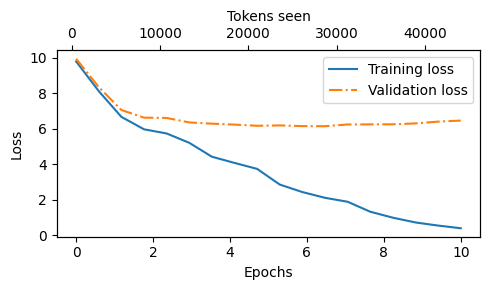

In [21]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- 학습이 진행될수록 문법적으로 그럴듯한 문장을 만들어 내지만 Validation Loss는 전혀 줄지 않음
    - Training data에 있는 내용이 그대로 나옴 => 과적합이 발생했음을 알 수 있음
    - 학습에 사용된 데이터가 너무 적어서 발생한 문제 ..
    - 이후 OpenAI에서 제공한 Pretrained Weights를 적용시켜 차이를 볼거임
- Gutenberg 데이터셋으로 더 많은 데이터 실험 가능

In [22]:
# NEW: use CPU here as inference is cheap with 
# this model and to ensure readers get same results in the
# remaining sections of this book
inference_device = torch.device("cpu")

model.to(inference_device)
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(inference_device),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed lun


- 모델의 학습 과정에서는 loss,Gradient 구하는 연산량이 상당히 많았지만 모델의 검증과정에서는 훨씬 연산량이 적어 CPU로도 충분하다.
    - 따라서 inference_device 에 cpu를 할당했음
- generate_text_simple 함수를 통한 모델의 추론은 같은 input에 대해서 항상 같은 output을 출력함
    - 이렇게 결정론적인 함수가 된 이유는 argmax를 통해 항상 가장 확률이 높은 토큰들만 출력하기 떄문
        - 같은 Weights을 가진 모델의 같은 input에 대한 추론은 항상 같은 output이 나오게됨 ..
    - 따라서 답변의 창의성, 다양성이 떨어지게됨
- 이를 해결하기 위해 Decoding Strategies 디코딩 전략을 도입

In [23]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

# Suppose input is "every effort moves you", and the LLM
# returns the following logits for the next token:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

# The next generated token is then as follows:
print(inverse_vocab[next_token_id])

torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward
forward


- argmax를 사용한 디코딩은 다음 토큰을 예측할때 가장 큰 토큰확률을 가진 토큰을 선택하게됨
    - **Greedy Decoding**
    - 위 예제에서는 항상 가장 높은 확률을 가진 토큰인 'forward'를 예측하게됨

- torch.multinomial(probas, num_samples=1).item() 을 통해 각 토큰이 가진 확률들에 따라 다음 토큰 하나를 뽑게 됨
    - **Random Sampling**
    - num_samples = 1 : 확률에 따라 1개만 선택하기
    - .item() : 텐서가 아닌 int,float과 같은 숫자를 뽑기

In [24]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward
0 x you


- 실제로 torch.multinomial를 많은 횟수로 수행해본다면 토큰이 나오는 횟수가 토큰의 확률분포와 유사한걸 알 수 있다 !

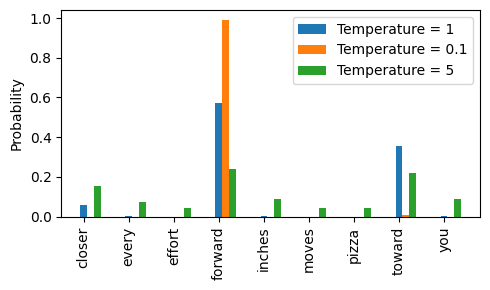

In [25]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

- Temperature Scaling 기법은 Softmax를 계산하기 전 logit값에 특정 상수인 온도(T)를 나눠주는 기법
    - **확률의 스케일링을 통해 토큰간의 차이**를 조정하기 위해 사용됨 !
- T=1 일 땐 모델이 학습한 확률을 그대로 사용함
- T<1 일 땐 확률들의 격차가 커진다. => 이미 높은 확률을 가진 토큰들은 더욱 확률이 높아지고 낮은 확률을 가진 토큰은 더욱 확률이 낮아진다.
    - 거의 Greedy Decoding과 유사해짐
- T>1 일 땐 확률들의 격차가 작아진다. => 모든 토큰들의 확률이 비슷해진다.


![random_sampling_with_temperature](random_sampling_with_temperature.png))

In [26]:
print_sampled_tokens(scaled_probas[1])

0 x closer
0 x every
0 x effort
985 x forward
0 x inches
0 x moves
0 x pizza
15 x toward
0 x you


- Temperature가 0.1 인 경우 argmax (Greedy Decoding)과 유사함을 알 수 있다.

In [27]:
print_sampled_tokens(scaled_probas[2])

165 x closer
75 x every
42 x effort
239 x forward
71 x inches
46 x moves
32 x pizza
227 x toward
103 x you


- Temperature가 5인 경우 고른 확률 분포를 볼 수 있다 ..

In [28]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


- Output의 다양성을 높이기 위해 T 를 높였을때 말도 안되는 토큰을 모델이 선택할 확률도 높아진다 ..
    - 이를 보완하기 위해 Top-K Sampling도 같이 사용한다. 

- 아래 이미지처럼 logit 값의 크기 순으로 k개의 토큰만 예측에 사용하는 기법이 Top-K Sampling이다.
    - 높은 logit(높은 확률을)을 가진 토큰들만 예측에 사용되므로 이상한 토큰을 예측할 가능성이 많이 줄어든다

![top_k_samling](https://camo.githubusercontent.com/7bc113d7a12a49a473a9059f425850564ce392aa34d8925e6edeb0a9558b73cb/68747470733a2f2f73656261737469616e72617363686b612e636f6d2f696d616765732f4c4c4d732d66726f6d2d736372617463682d696d616765732f636830355f636f6d707265737365642f31352e77656270)

In [29]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top logits:", top_logits)
print("Top positions:", top_pos)

new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")), 
    other=next_token_logits
)

new_logits_alt = torch.full_like( # create tensor containing -inf values
   next_token_logits, -torch.inf
)   
new_logits[top_pos] = next_token_logits[top_pos] # copy top k values into the -inf tensor


print(new_logits)

topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])
tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])
tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


- 위 예제는 Top-K Sampling을 직접 구현함
    - 모델이 계산한 logit값에 예측에 사용되지 않은 토큰 n-k개의 logit을 -torch.inf로 초기화함 (new_logits)
        - 저자는 미리 -torch.inf로 구성된 텐서에서 k개의 토큰만 확률값을 넣어주는 방법이 더 빠를것 같다고 제안함 (new_logits_alt)
- Top-K를 거친 logit값을 Softmax를 태워보면 K개의 토큰을 제외하고 확률이 0인걸 볼 수 있음

In [30]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # New (not in book): numerical stability tip to get equivalent results on mps device
            # subtract rowwise max before softmax
            logits = logits - logits.max(dim=-1, keepdim=True).values
            
            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx


- generate 함수를 통해 Temperature/Top-K Sampling 이 적용된 모델 예측을 구현하였다
    ```python
    logits = logits[:, -1, :]
    ```
    - 우리가 이번에 필요한건 마지막 토큰 다음에 어떤 토큰이 나오는가임
    ```python
    logits = logits - logits.max(dim=-1, keepdim=True).values 
    ```
    - Softmax 계산 시 값이 너무 커지는 걸 방지하기 위한 방법
    ```python
    idx = torch.cat((idx, idx_next), dim=1)
    ```
    - 예측한 토큰을 다음 input에 붙여넣음

In [31]:
torch.save(model.state_dict(), "model.pth")

- 모델의 파라미터(Weights / Biases)를 파이썬 딕셔너리 형태로 저장함

In [32]:
model = GPTModel(GPT_CONFIG_124M)

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # Use PyTorch 2.9 or newer for stable mps results
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Device:", device)

model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
model.eval();

Device: cpu


- model.load_state_dict() 함수를 통해 현재 모델 instance에 이전에 학습된 가중치를 넣게 됨
    - map_location=device : 모델에서 학습했을 때 환경과 현재 환경이 다를 경우 에러가 발생하므로 현재 사용가능한 device로 파라미터를 적용
    - weights_only=True : 보안을 위해 파일에 존재하는 Weights만 사용함

In [33]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, 
    "model_and_optimizer.pth"
)

checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

- 일반적으로 LLM 학습 시에는 단순 SGD로 학습하는거보다 Adam/AdamW 같은 Adapative Optimizer를 사용함
    - Optimizer를 사용할 경우 이 후에도 이 모델을 Pretraining 하기 위해서는 모델과 함께 Optimizer도 같이 저장해야함

- Optimizer를 저장하면 같이 저장했던 모델의 마지막 Pretraining 당시 momentum을 기억하게됨 ..
    - 초기 loss도 안튀고 학습 속도도 빨라짐

In [34]:
import requests
import urllib.request

file_name = "gpt2-small-124M.pth"
url = f"https://huggingface.co/rasbt/gpt2-from-scratch-pytorch/resolve/main/{file_name}"

if not os.path.exists(file_name):
    urllib.request.urlretrieve(url, file_name) # 파일이 없으면 다운로드
    print(f"Downloaded to {file_name}")

GPT_CONFIG_124M.update({"context_length": 1024, "qkv_bias": True})
gpt = GPTModel(GPT_CONFIG_124M)

- 저자가 경고하길 GPT-2가 Tensorflow로 만들어져서 원본 모델 파일도 Tensorflow용임 ..
- 근데 우리는 Torch를 쓰기 때문에 자기가 이미 편~안하게 GPT-2를 torch용으로 바꿔놨다 그니까 갖다 써라 ~ 라고 함
    - 감사합니다 ..
- gpt2-small-124M : GPT 모델 중 가장 작은거 (파라미터 1억개..)
- 이전 예제에서 사용했던 GPT_CONFIG_124M 그대로 사용했다 ..
- 우리가 사용할 gpt2-small-124M은 INPUT length가 토큰 1024개 이므로 CONFIG를 맞춰준다.

- 아래는 우리가 사용할 gpt 2m 모델의 간략한 구조임
![gpt2m_design](https://camo.githubusercontent.com/5435c19ef837e8a269b9f829af032ce0103519a6bd3d1030abdda58a6db498a1/68747470733a2f2f73656261737469616e72617363686b612e636f6d2f696d616765732f4c4c4d732d66726f6d2d736372617463682d696d616765732f636830355f636f6d707265737365642f31372e77656270)

In [35]:
import torch

checkpoint = torch.load("gpt2-small-124M.pth", map_location=device, weights_only=True)

gpt.load_state_dict(checkpoint, strict=False)

gpt.to(device);

In [36]:
gpt.eval()

torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=1024,
    top_k=50,
    temperature=1.5
)
with torch.no_grad():
    gpt2m_val_loss = calc_loss_loader(val_loader, gpt, device)
    hommade_val_loss = calc_loss_loader(val_loader,model,device)
    
    
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

print("GPT 2M validation loss",gpt2m_val_loss)

print("Our model validation loss",hommade_val_loss)


Output text:
 Every effort moves you toward finding an ideal new way to practice something!

What makes us want to be on top of that?


GPT 2M validation loss 3.559627056121826
Our model validation loss 6.452609062194824


- 아주 정확한 OUTPUT을 보여주는걸 볼 수 있음